# Transfer Learning

We can either 
- use the convolutional layers merely as a <i><b>feature extractor</b></i> 
- or we can <i><b>tweak</b></i> the already trained convolutional layers to suit our problem at hand. 
The former approach is known as <i><b>Transfer Learning</b></i> and the latter as <i><b>Fine-tuning</b></i>.

As a rule of thumb
- when we have a small training set and our problem is similar to the task for which the pre-trained models were trained, we can use transfer learning. 
- Otherwise if we have enough data, we can try and tweak the convolutional layers so that they learn more robust features relevant to our problem. 

You can get a detailed overview of Fine-tuning and transfer learning here: https://cs231n.github.io/transfer-learning/



## attenzione: current working directory = CWD

## We will discuss Transfer Learning in Keras in this post.

# 1) Download and prepare Data

Two options:
- For downloading Imagenet images by wnid, there is a nice code repository written by Tzuta Lin which is available on GitHub. You can use this to download images of a specific “wnid”. You can visit the GitHub page and follow the instructions to download the images for any of the wnid’s
- However, If you are just starting out and do not want to download full-size images, you can use another python library available through pip – imagenetscraper. It is easy to use and also provides resizing options. Installation and usage instructions are provided below. Note that it works with python3 only

We will proceed for option 2

In [1]:
#pip install zipfile

In [2]:
#pip install zipfile36

In [3]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import vgg16
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img

from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import Sequential, optimizers

import os
import random 

import zipfile as zf

%matplotlib inline

In [7]:
'''
# BASTA FARLO LA PRIMA VOLTA E' GIA' STATO FATTO
files = zf.ZipFile("potato_white.zip", 'r')
files.extractall('fruits\potato')
files.close()
'''

'\n# BASTA FARLO LA PRIMA VOLTA E\' GIA\' STATO FATTO\nfiles = zf.ZipFile("potato_white.zip", \'r\')\nfiles.extractall(\'fruits\\potato\')\nfiles.close()\n'

In [8]:
'''
# BASTA FARLO LA PRIMA VOLTA E' GIA' STATO FATTO
files = zf.ZipFile("watermelon.zip", 'r')
files.extractall('fruits\watermelon')
files.close()
'''

'\n# BASTA FARLO LA PRIMA VOLTA E\' GIA\' STATO FATTO\nfiles = zf.ZipFile("watermelon.zip", \'r\')\nfiles.extractall(\'fruits\\watermelon\')\nfiles.close()\n'

In [9]:
'''
# BASTA FARLO LA PRIMA VOLTA E' GIA' STATO FATTO
files = zf.ZipFile("tomato.zip", 'r')
files.extractall('fruits\tomato')
files.close()
'''

'\n# BASTA FARLO LA PRIMA VOLTA E\' GIA\' STATO FATTO\nfiles = zf.ZipFile("tomato.zip", \'r\')\nfiles.extractall(\'fruits\tomato\')\nfiles.close()\n'

Now all three types of fruits and vegetables are in the right folder.
Let's proceed.

# 2) Load the pre-trained model

In [10]:
vgg_conv = vgg16.VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))

In [11]:
vgg_conv.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In the above code, we load the VGG Model along with the ImageNet weights similar to our previous tutorial. There is, however, one change: <i><b>include_top=False</b></i>. 

<b>We have not loaded the last two fully connected layers which act as the classifier. We are just loading the convolutional layers</b>. It should be noted that the last layer has a shape of 7 x 7 x 512

# 3) Extract Features

In [12]:
import os.path
watermelon_path_train = 'fruits\\train\watermelon'
potato_path_train = 'fruits\\train\potato'
tomato_path_train = 'fruits\\train\\tomato'

In [13]:
watermelon_num_train = len([f for f in os.listdir(watermelon_path_train)if os.path.isfile(os.path.join(watermelon_path_train, f))])
potato_num_train = len([f for f in os.listdir(potato_path_train)if os.path.isfile(os.path.join(potato_path_train, f))])
tomato_num_train = len([f for f in os.listdir(tomato_path_train)if os.path.isfile(os.path.join(tomato_path_train, f))])

In [14]:
train_num = watermelon_num_train + potato_num_train + tomato_num_train
train_num

600

In [15]:
watermelon_path_test = 'fruits\\test\watermelon'
potato_path_test = 'fruits\\test\potato'
tomato_path_test = 'fruits\\test\\tomato'

In [16]:
watermelon_num_test = len([f for f in os.listdir(watermelon_path_test)if os.path.isfile(os.path.join(watermelon_path_test, f))])
potato_num_test = len([f for f in os.listdir(potato_path_test)if os.path.isfile(os.path.join(potato_path_test, f))])
tomato_num_test = len([f for f in os.listdir(tomato_path_test)if os.path.isfile(os.path.join(tomato_path_test, f))])

In [17]:
test_num = watermelon_num_test + potato_num_test + tomato_num_test
test_num

150

In [18]:
train_dir = 'fruits\\train'
test_dir = 'fruits\\test'

In [19]:
train_dir

'fruits\\train'

In [33]:
# load the normalized images
datagen = ImageDataGenerator(rescale=1./255)

# define the batch size
batch_size = 20

# the defined shape is equal to the network output tensor shape
train_features = np.zeros(shape=(train_num, 7, 7, 512))
train_labels = np.zeros(shape=(train_num,3))

# generate batches of train images and labels
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True)

Found 600 images belonging to 3 classes.


In [34]:
train_labels.shape

(600, 3)

In [35]:
train_generator

Then we use <i><b>model.predict()</b></i> function to pass the image through the network which gives us a 7 x 7 x 512 dimensional Tensor. We reshape the Tensor into a vector. Similarly, we find the validation_features.

## Optional: VIsualize the training dataset

The shape of train images: (224, 224, 3)


Text(0.5, 1.0, 'Class name: potato')

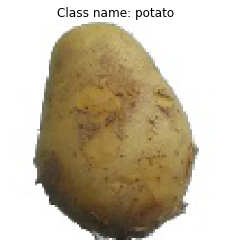

In [36]:
# choose the image index for the visualization
image_id = 0

# get the train image shape 
print("The shape of train images: {}".format(train_generator[image_id][0][0].shape))

# visualize the image example
plt.axis('off')
plt.imshow(train_generator[image_id][0][0])

# get image class and map its index with the names of the classes
train_image_label_id = np.argmax(train_generator[image_id][1][0])
classes_list = list(train_generator.class_indices.keys())

# show image class
plt.title("Class name: {}".format(classes_list[train_image_label_id]))

# 4) Obtain model predictions on the train data
Get the predictions passing the images from train dataset into the model:

In [37]:
enumerate(train_generator)

In [39]:
# iterate through the batches of train images and labels
for i, (inputs_batch, labels_batch) in enumerate(train_generator):
    if i * batch_size >= train_num:
        break    
    # pass the images through the network
    features_batch = vgg_conv.predict(inputs_batch)
    #print('Features batch: ')
    #print(features_batch)
    train_features[i * batch_size : (i + 1) * batch_size] = features_batch
    #print('Features batch: ')
    #print(features_batch)
    train_labels[i * batch_size : (i + 1) * batch_size] = labels_batch
    #print('Labelss batch: ')
    #print(labels_batch)

# reshape train_features into vector        
train_features_vec = np.reshape(train_features, (train_num, 7 * 7 * 512))
print("Train features: {}".format(train_features_vec.shape))

Features batch: 
[[[[5.75115085e-02 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    6.63824439e-01 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    4.47708875e-01 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    5.61859846e-01 0.00000000e+00]
   ...
   [0.00000000e+00 0.00000000e+00 3.21556568e-01 ... 0.00000000e+00
    7.56752670e-01 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 6.08011484e-02 ... 0.00000000e+00
    9.86667037e-01 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    7.02757955e-01 0.00000000e+00]]

  [[2.66466349e-01 0.00000000e+00 1.88300580e-01 ... 0.00000000e+00
    4.64377403e-01 0.00000000e+00]
   [7.02328384e-01 0.00000000e+00 1.12265444e+00 ... 7.39336461e-02
    4.25474823e-01 0.00000000e+00]
   [1.06407309e+00 0.00000000e+00 9.55323696e-01 ... 1.58203766e-01
    8.10298979e-01 0.00000000e+00]
   ...
   [1.18853498e+00 0.00000000e+00 1.1593

# 5) Prepare the validation data

In [48]:
validation_features = np.zeros(shape=(test_num, 7, 7, 512))
validation_labels = np.zeros(shape=(test_num,3))

# generate batches of validation images and labels
validation_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    classes=['potato', 'tomato', 'watermelon'],
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

Found 150 images belonging to 3 classes.


In [49]:
type(validation_generator)

keras_preprocessing.image.directory_iterator.DirectoryIterator

6) Visualize the validation data

The shape of validation images: (224, 224, 3)


Text(0.5, 1.0, 'Class name: potato')

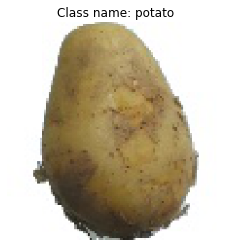

In [50]:
# choose the image index for the visualization
val_image_id = 0

# get the validation image shape 
print("The shape of validation images: {}".format(validation_generator[val_image_id][0][0].shape))

# visualize the image example
plt.axis('off')
plt.imshow(validation_generator[val_image_id][0][0])

# get image class and map its index with the names of the classes
val_image_label_id = np.argmax(validation_generator[val_image_id][1][0])
classes_list = list(validation_generator.class_indices.keys())

# show image class
plt.title("Class name: {}".format(classes_list[val_image_label_id]))

In [51]:
for i, (inputs_batch, labels_batch) in enumerate(validation_generator):
    if i * batch_size >= test_num:
        break
    features_batch = vgg_conv.predict(inputs_batch)
    validation_features[i * batch_size : (i + 1) * batch_size] = features_batch
    validation_labels[i * batch_size : (i + 1) * batch_size] = labels_batch

# reshape validation_features into vector 
validation_features_vec = np.reshape(validation_features, (test_num, 7 * 7 * 512))
print("Validation features: {}".format(validation_features_vec.shape))

Validation features: (150, 25088)


# Experiment 2: Create your own model and train the network

In [52]:
model = Sequential()
model.add(Dense(512, activation='relu', input_dim=7 * 7 * 512))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

# configure the model for training
model.compile(optimizer=optimizers.RMSprop(lr=2e-4),
              loss='categorical_crossentropy',
              metrics=['acc'])

# use the train and validation feature vectors 
history = model.fit(train_features_vec,
                    train_labels,
                    epochs=20,
                    batch_size=batch_size,
                    validation_data=(validation_features_vec,validation_labels))

Train on 600 samples, validate on 150 samples
Epoch 1/20
600/600 [==============================] - 6s 10ms/sample - loss: 0.5822 - acc: 0.9033 - val_loss: 0.0022 - val_acc: 1.0000
Epoch 2/20
600/600 [==============================] - 5s 8ms/sample - loss: 0.0027 - acc: 1.0000 - val_loss: 2.1767e-04 - val_acc: 1.0000
Epoch 3/20
600/600 [==============================] - 5s 8ms/sample - loss: 6.0046e-04 - acc: 1.0000 - val_loss: 7.4243e-05 - val_acc: 1.0000
Epoch 4/20
600/600 [==============================] - 5s 8ms/sample - loss: 9.2734e-05 - acc: 1.0000 - val_loss: 3.5411e-05 - val_acc: 1.0000
Epoch 5/20
600/600 [==============================] - 6s 9ms/sample - loss: 0.0654 - acc: 0.9817 - val_loss: 8.2732e-06 - val_acc: 1.0000
Epoch 6/20
600/600 [==============================] - 6s 9ms/sample - loss: 5.4441e-05 - acc: 1.0000 - val_loss: 4.1237e-06 - val_acc: 1.0000
Epoch 7/20
600/600 [==============================] - 6s 10ms/sample - loss: 4.7732e-05 - acc: 1.0000 - val_loss: 2.1

In [53]:
# get the list of all validation file names
fnames = validation_generator.filenames

# get the list of the corresponding classes
ground_truth = validation_generator.classes

# get the dictionary of classes
label2index = validation_generator.class_indices

# obtain the list of classes
idx2label = list(label2index.keys())
print("The list of classes: ", idx2label)

The list of classes:  ['potato', 'tomato', 'watermelon']


In [54]:
predictions = model.predict_classes(validation_features_vec)
prob = model.predict(validation_features_vec)

In [56]:
errors = np.where(predictions != ground_truth)[0]
print("Number of errors = {}/{}".format(len(errors),test_num))

Number of errors = 0/150


In [57]:
# DA PROVARE QUANDO SI AVRANNO ERRORI 
# TALE PORZIONE I CODICE PERMETE DI STAMPARE LE IMAGGINI SBAGLIATE CN LA PREDIZIONE EFFETUATA
# CREDO SIA UNA BELLA COSA, QUALORA DOVESSE SERVIRE COMUNQUE E' PRONTA

'''
for i in range(len(errors)):
    pred_class = np.argmax(prob[errors[i]])
    pred_label = idx2label[pred_class]
    
    print('Original label:{}, Prediction :{}, confidence : {:.3f}'.format(
        fnames[errors[i]].split('/')[0],
        pred_label,
        prob[errors[i]][pred_class]))
    
    original = load_img('{}/{}'.format(validation_dir,fnames[errors[i]]))
    plt.axis('off')
    plt.imshow(original)
    plt.show()
'''

"\nfor i in range(len(errors)):\n    pred_class = np.argmax(prob[errors[i]])\n    pred_label = idx2label[pred_class]\n    \n    print('Original label:{}, Prediction :{}, confidence : {:.3f}'.format(\n        fnames[errors[i]].split('/')[0],\n        pred_label,\n        prob[errors[i]][pred_class]))\n    \n    original = load_img('{}/{}'.format(validation_dir,fnames[errors[i]]))\n    plt.axis('off')\n    plt.imshow(original)\n    plt.show()\n"